In [20]:
import yfinance as yf
import pandas as pd
import numpy as np

#https://it.tradingview.com/markets/stocks-usa/sectorandindustry-sector/technology-services/
stocks = ["AAPL", "META", "ORCL", "MSFT"]

In [21]:
def add_indicators(data):
    # Calculate return
    data["Return"] = data["Close"].pct_change()

    window = 20  # Finestra 20 giorni perchè conicide con la Middle Bollinger Band
    # Simple Moving Average (SMA)
    data['SMA20'] = data['Close'].rolling(window=window).mean()

    # Exponential Moving Average (EMA)
    data['EMA20'] = data['Close'].ewm(span=window).mean()

    # Weited Moving Average (WMA)
    pesi = np.arange(1, window+1)
    data['WMA20'] = data["Close"].rolling(window=window).apply(lambda prices: np.dot(prices, pesi)/pesi.sum(), raw=True)

    #Relative Strenght index
    delta = data["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    data["RSI"] = rsi
    
    # Moving Average Convergence Divergence
    short = 12
    long = 26
    signal = 9

    data["MACD"] = data["Close"].ewm(span=short, adjust=False).mean() - data["Close"].ewm(span=long, adjust=False).mean()
    data["Signal_Line"] = data["MACD"].ewm(span=signal, adjust=False).mean()

    # Standard deviation
    data["STD20"] = data["Close"].rolling(window=window).std()

    # Bollinger Bands
    data["Boll_Up"] = data["SMA20"] + 2 * data["STD20"]
    data["Boll_Down"] = data["SMA20"] - 2 * data["STD20"]
    
    return data

for stock in stocks:
    data = yf.download(stock, start="2020-01-01", end="2025-09-01", auto_adjust=True)
    avanced_data = add_indicators(data)
    if avanced_data is not None:
        avanced_data.to_csv(f"{stock}_indicators.csv")
    else:
        print(f"Warning: No data for {stock}, skipping CSV export.")


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Training set size: 1239
Testing set size: 165
====================AAPL=
Mean Squared Error (MSE): 1.97
Root Mean Squared Error (RMSE): 1.40
Mean Absolute Error (MAE): 1.07
R² Score: 0.9921
PREDICTION SUMMARY:
Average actual price: $216.47
Average predicted price: $216.72
Error as % of avg price: 0.49%


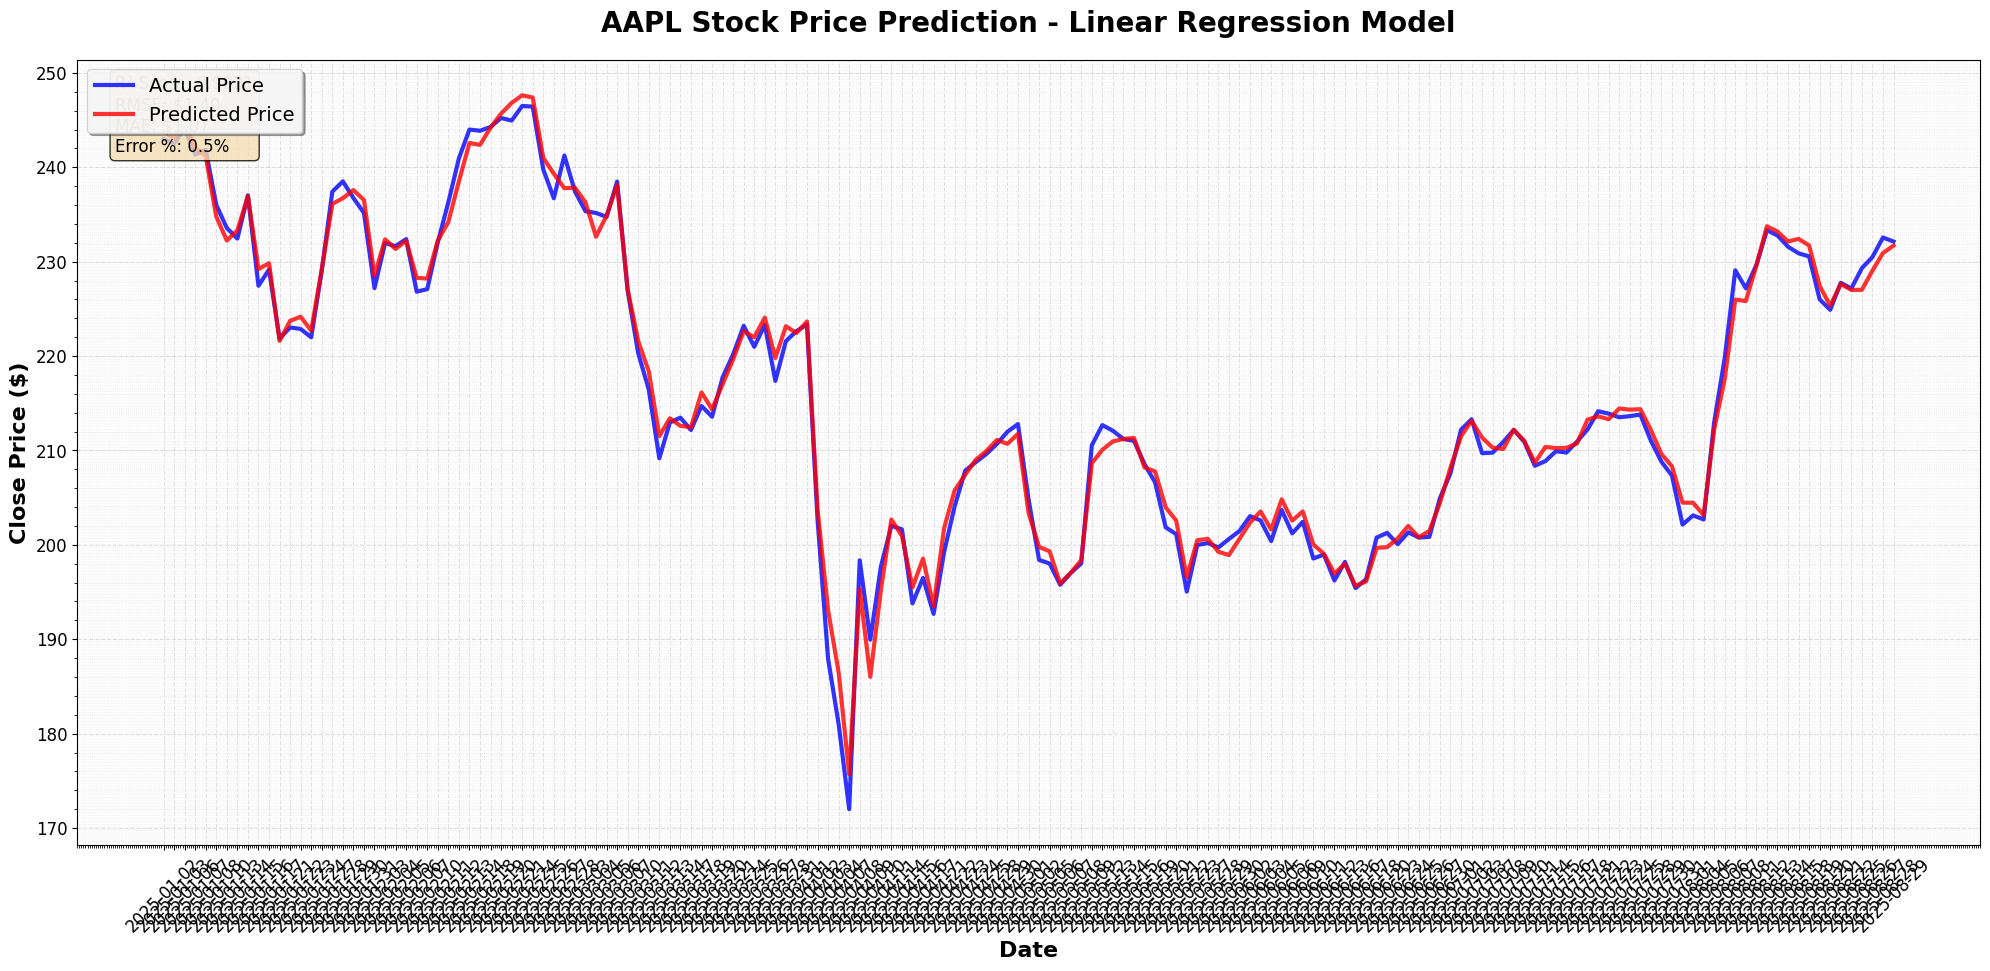

Training set size: 1239
Testing set size: 165
====================META=
Mean Squared Error (MSE): 19.09
Root Mean Squared Error (RMSE): 4.37
Mean Absolute Error (MAE): 3.40
R² Score: 0.9964
PREDICTION SUMMARY:
Average actual price: $658.31
Average predicted price: $658.20
Error as % of avg price: 0.52%


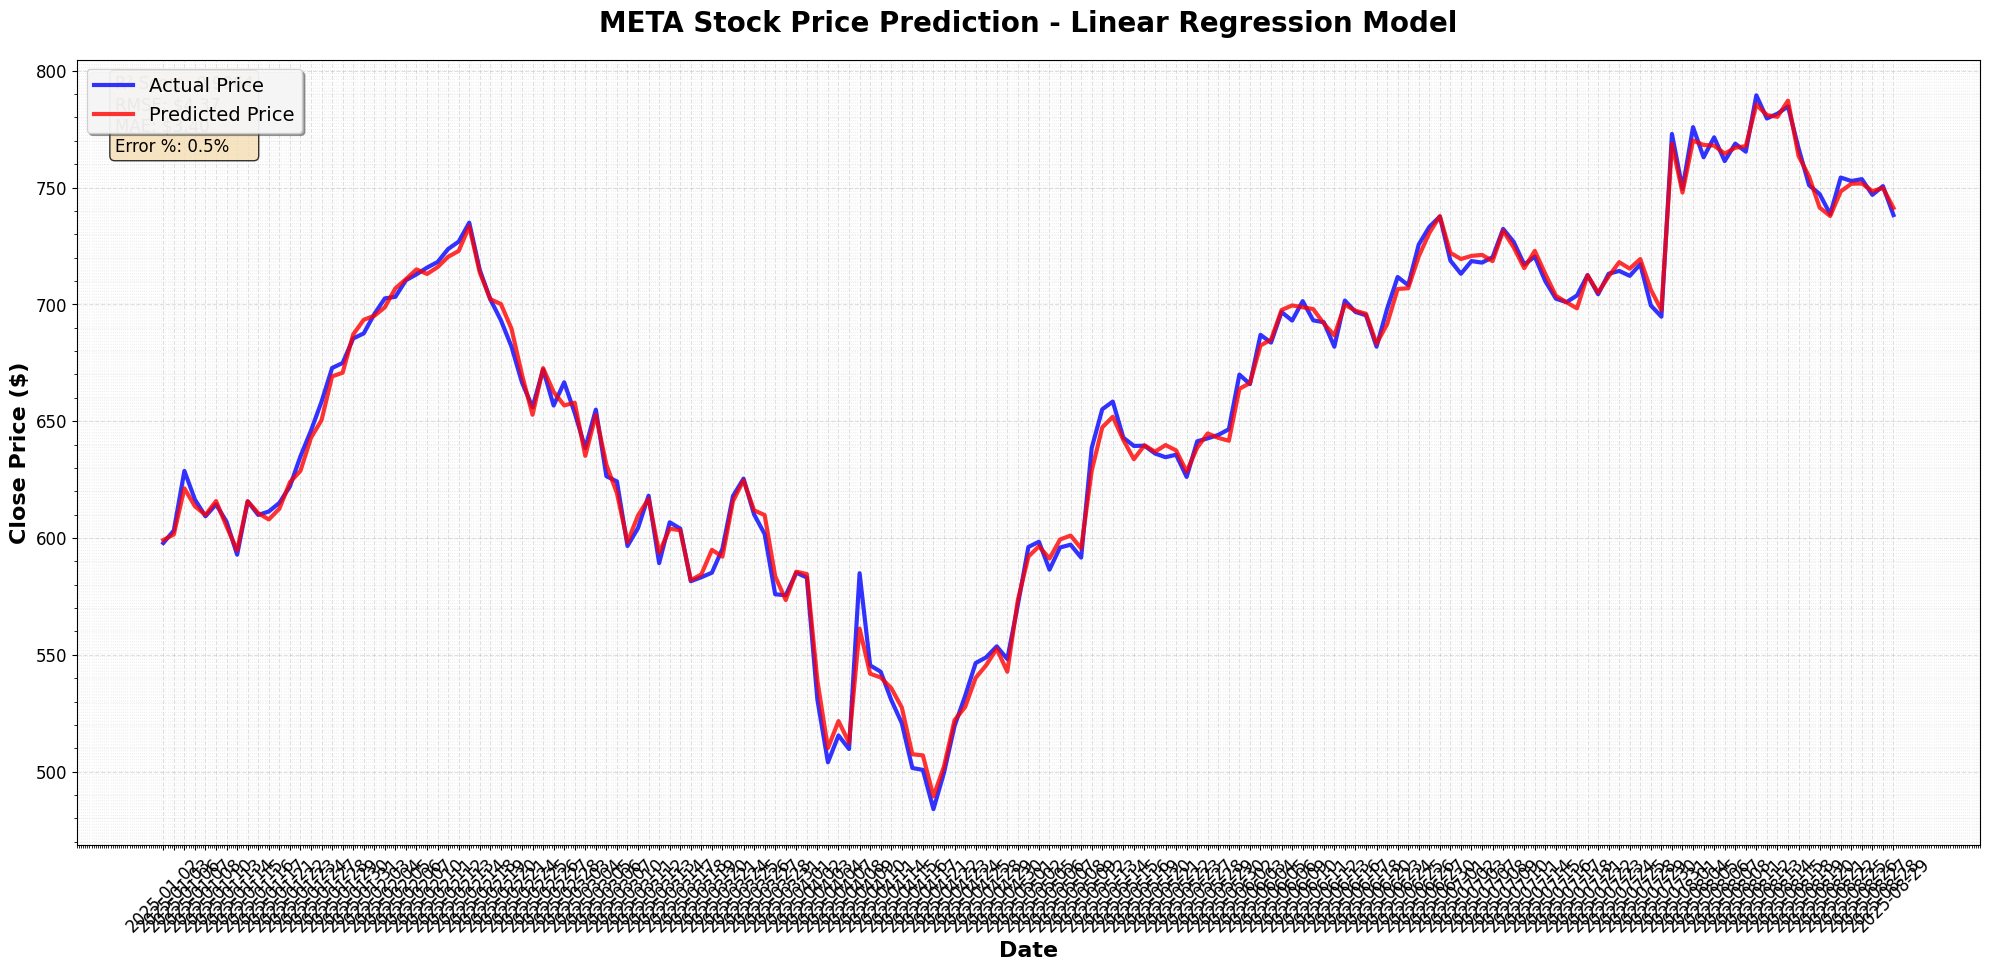

Training set size: 1239
Testing set size: 165
====================ORCL=
Mean Squared Error (MSE): 1.85
Root Mean Squared Error (RMSE): 1.36
Mean Absolute Error (MAE): 1.06
R² Score: 0.9988
PREDICTION SUMMARY:
Average actual price: $182.27
Average predicted price: $182.05
Error as % of avg price: 0.58%


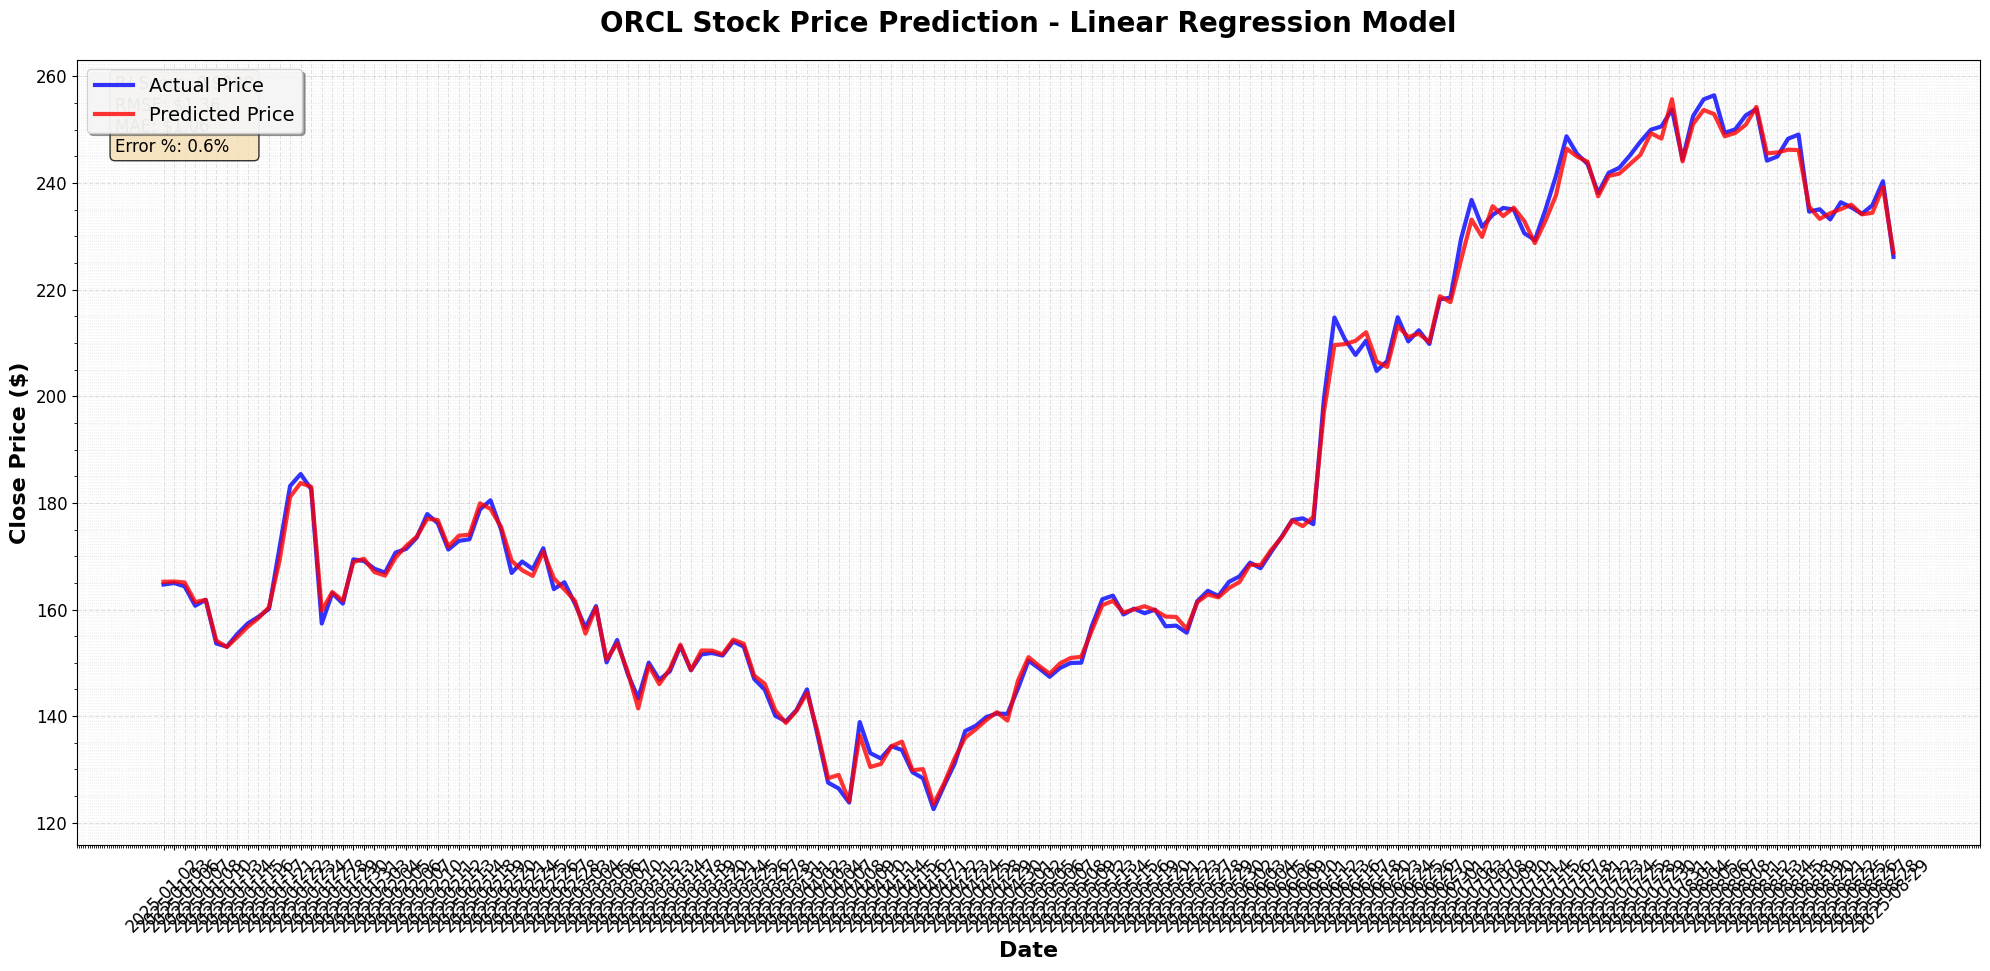

Training set size: 1239
Testing set size: 165
====================MSFT=
Mean Squared Error (MSE): 3.18
Root Mean Squared Error (RMSE): 1.78
Mean Absolute Error (MAE): 1.28
R² Score: 0.9988
PREDICTION SUMMARY:
Average actual price: $443.39
Average predicted price: $443.34
Error as % of avg price: 0.29%


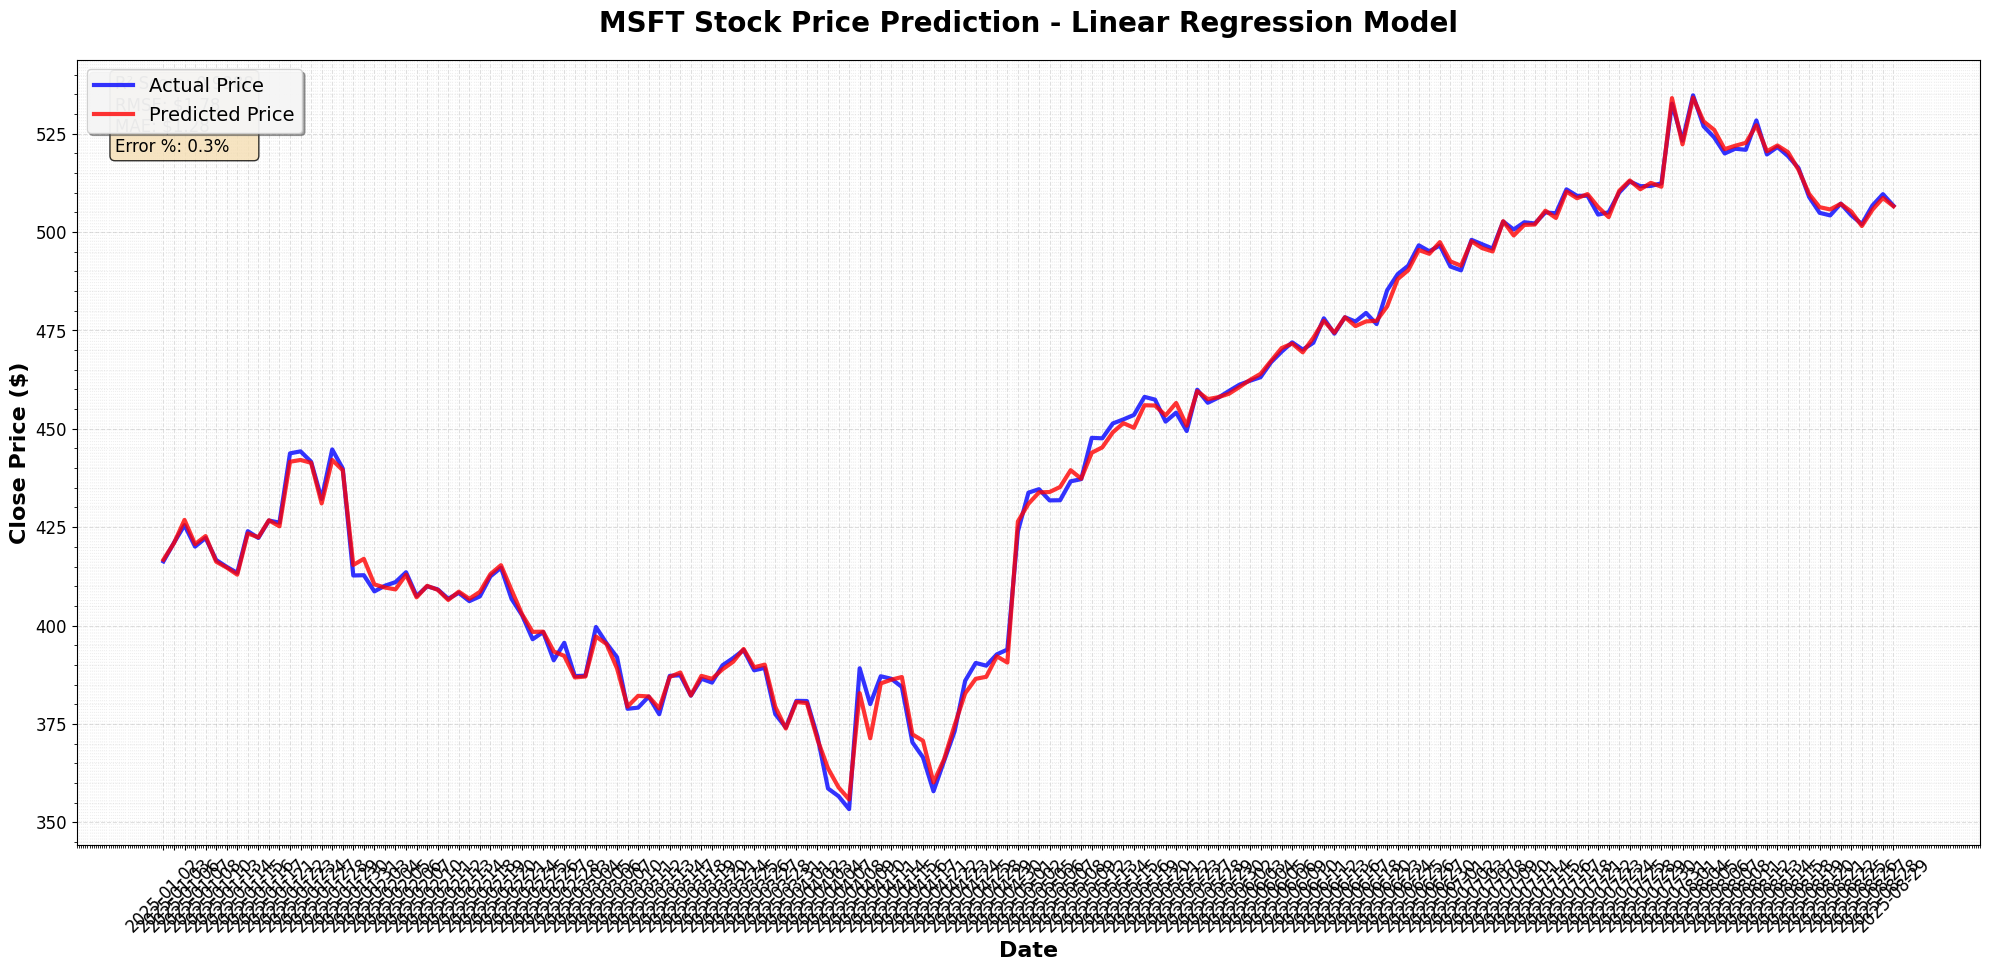

In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

for stock in stocks:
    # Load the data from the CSV file created in previous cell (with technical indicators)
    df = pd.read_csv(
        f"{stock}_indicators.csv",
        index_col=0,       # use first column ("Date") as index
        parse_dates=[0],    # parse it as datetime
        date_format="ISO8601" #Specify date fromat
    )
    df = df.dropna()

    # Prepare features and target
    Y = df["Close"]
    X = df.drop(columns=["Close"])

    # Time-based split: train before 2024, test from 2024 onwards
    X_train, X_test = X[X.index < "2025-01-01"], X[X.index >= "2025-01-01"]
    y_train, y_test = Y[Y.index < "2025-01-01"], Y[Y.index >= "2025-01-01"]

    # Convert y_train and y_test to float (fix for UFuncTypeError)
    y_train = pd.to_numeric(y_train, errors='coerce')
    y_test = pd.to_numeric(y_test, errors='coerce')

    print("="*50)
    print(f"Training set size: {len(X_train)}")
    print(f"Testing set size: {len(X_test)}")

    # Scale features for better performance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Init of model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Error manipulation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("="*20 + f"{stock}" + "="*20)
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R² Score: {r2:.4f}")

    print("PREDICTION SUMMARY:")
    print(f"Average actual price: ${y_test.mean():.2f}")
    print(f"Average predicted price: ${y_pred.mean():.2f}")
    print(f"Error as % of avg price: {(mae/y_test.mean())*100:.2f}%")

    # Enhanced plot with better readability
    plt.figure(figsize=(20, 10))
    plt.plot(y_test.index, y_test, label='Actual Price', alpha=0.8, linewidth=3, color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted Price', alpha=0.8, linewidth=3, color='red')

    # Improved title and labels with larger font sizes
    plt.title(f"{stock} Stock Price Prediction - Linear Regression Model", 
            fontsize=20, fontweight='bold', pad=20)
    plt.xlabel('Date', fontsize=16, fontweight='bold')
    plt.ylabel('Close Price ($)', fontsize=16, fontweight='bold')

    # Enhanced legend
    plt.legend(fontsize=14, loc='upper left', framealpha=0.9, shadow=True)

    # Improved grid
    plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)

    # Better tick formatting
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)

    # Add performance metrics as text box on the plot
    textstr = f'R² Score: {r2:.4f}\nRMSE: ${rmse:.2f}\nMAE: ${mae:.2f}\nError %: {(mae/y_test.mean())*100:.1f}%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Improve layout and spacing
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)

    # Optional: Add minor grid for better precision reading
    plt.gca().grid(True, which='minor', alpha=0.2, linestyle=':')
    plt.gca().minorticks_on()

    plt.show()




ANALYZING AAPL
Training set: 1239, Testing set: 165

Linear Regression Results:
RMSE: $1.40 | MAE: $1.07 | R²: 0.9921

Random Forest Results:
RMSE: $3.59 | MAE: $2.64 | R²: 0.9480

Gradient Boosting Results:
RMSE: $3.53 | MAE: $2.67 | R²: 0.9499

 BEST MODEL: Linear Regression (RMSE: $1.40)


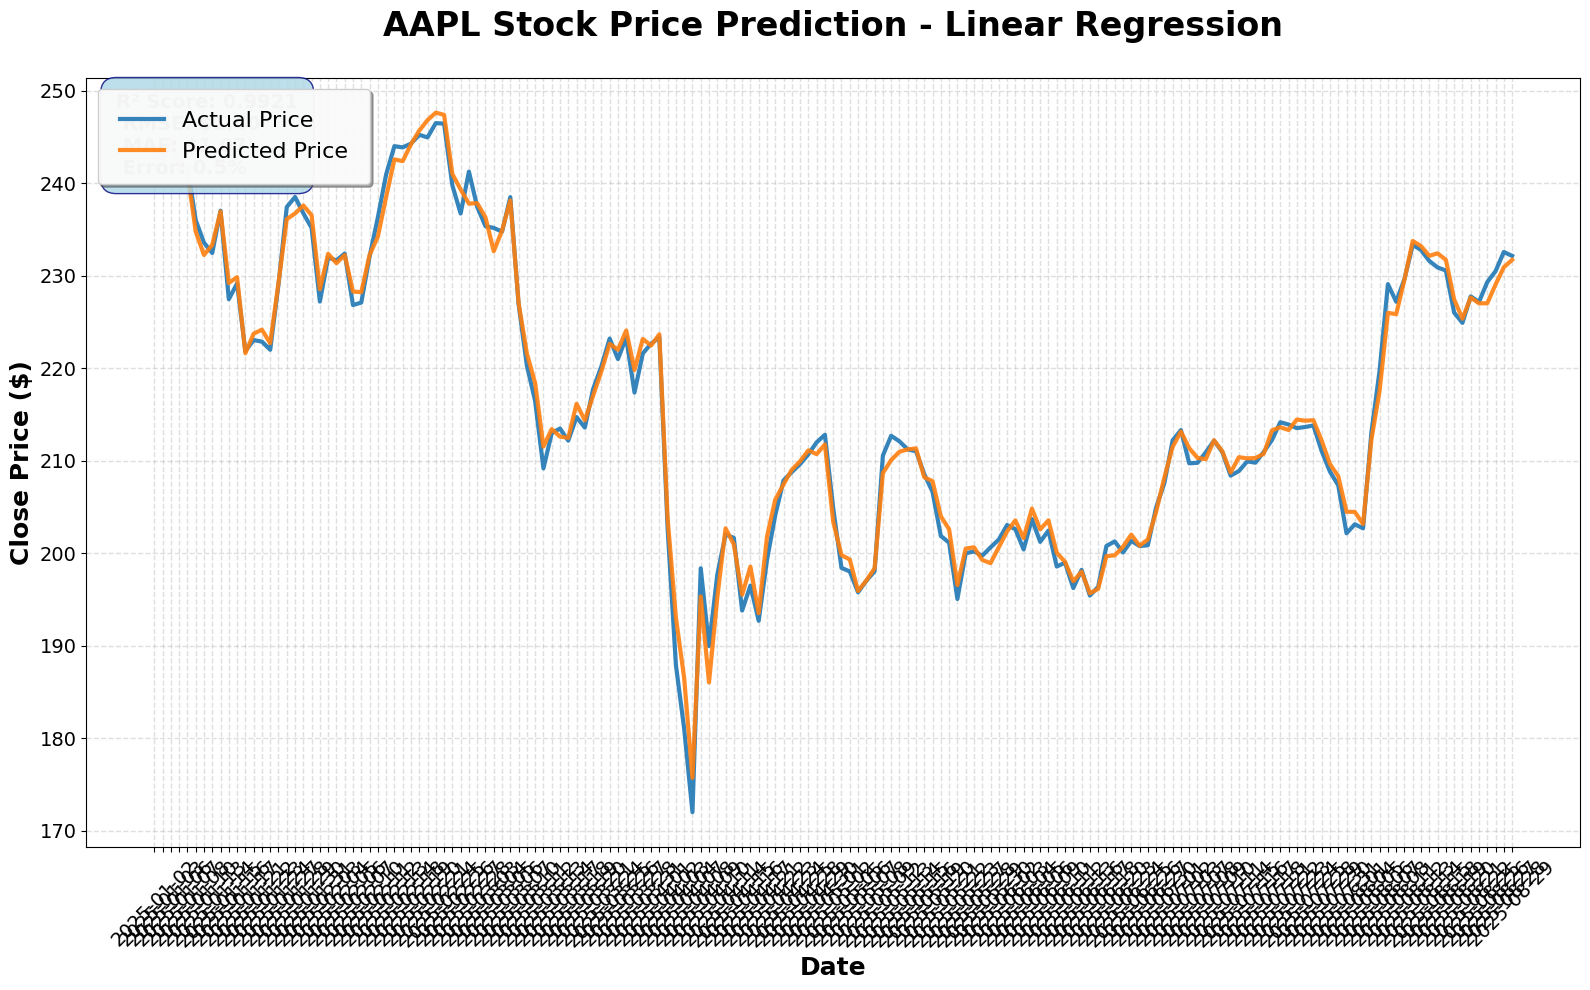


ANALYZING META
Training set: 1239, Testing set: 165

Linear Regression Results:
RMSE: $4.37 | MAE: $3.40 | R²: 0.9964

Random Forest Results:
RMSE: $72.66 | MAE: $54.26 | R²: -0.0072

Gradient Boosting Results:
RMSE: $69.51 | MAE: $51.57 | R²: 0.0781

 BEST MODEL: Linear Regression (RMSE: $4.37)


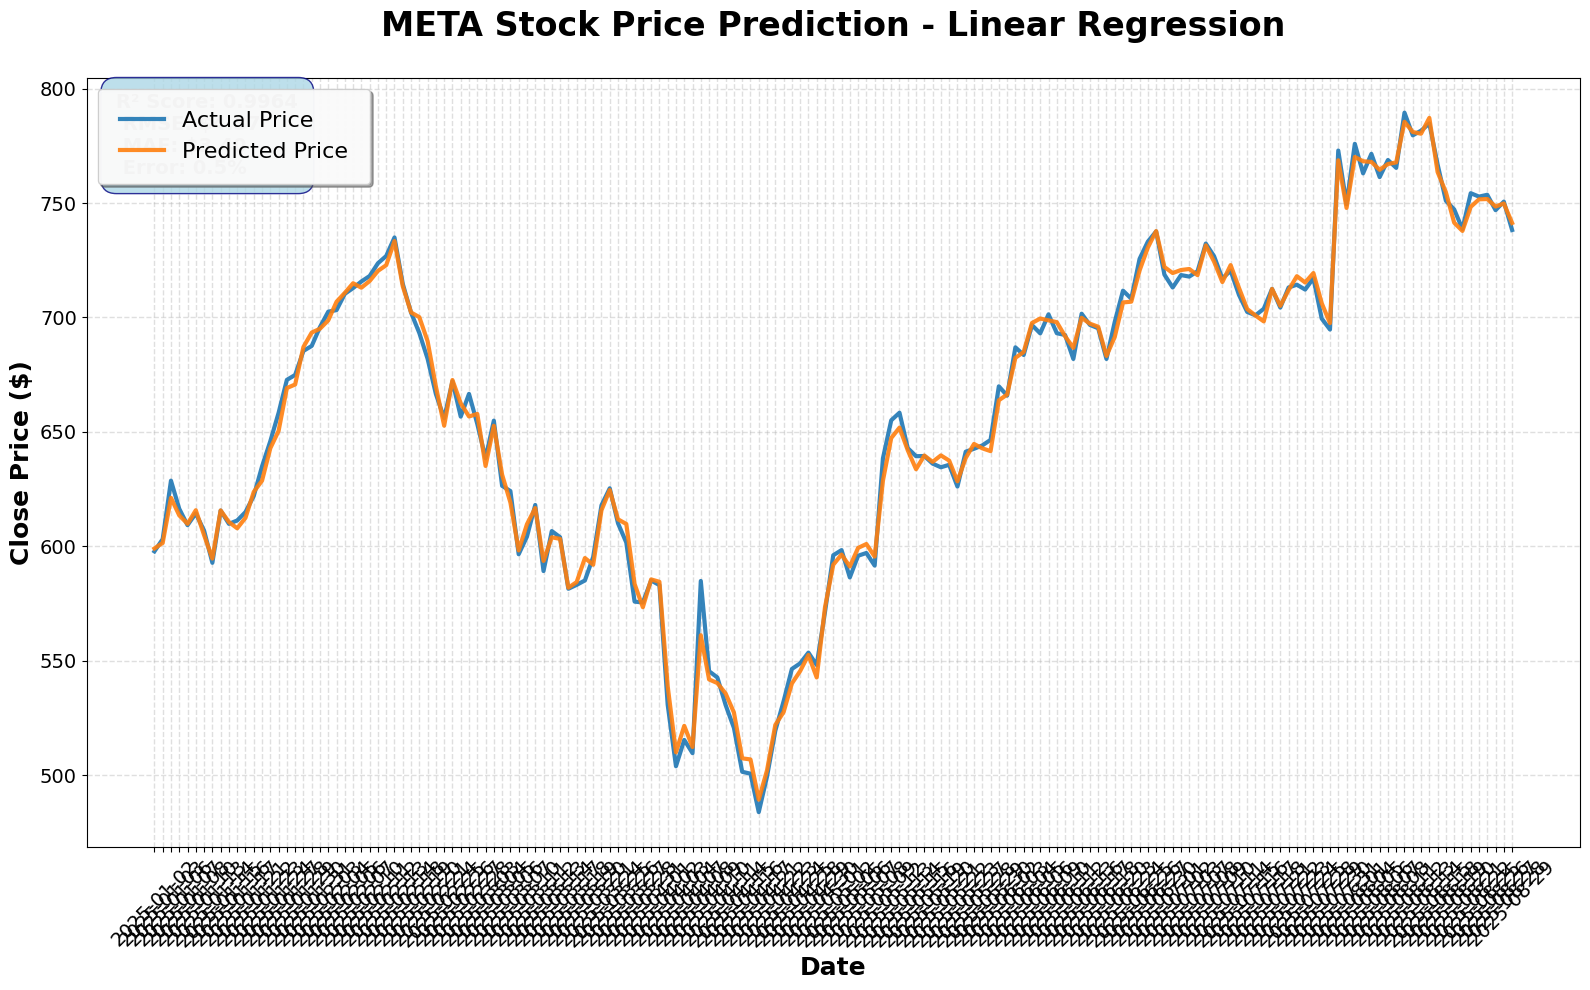


ANALYZING ORCL
Training set: 1239, Testing set: 165

Linear Regression Results:
RMSE: $1.36 | MAE: $1.06 | R²: 0.9988

Random Forest Results:
RMSE: $27.75 | MAE: $17.37 | R²: 0.5144

Gradient Boosting Results:
RMSE: $27.01 | MAE: $17.05 | R²: 0.5398

 BEST MODEL: Linear Regression (RMSE: $1.36)


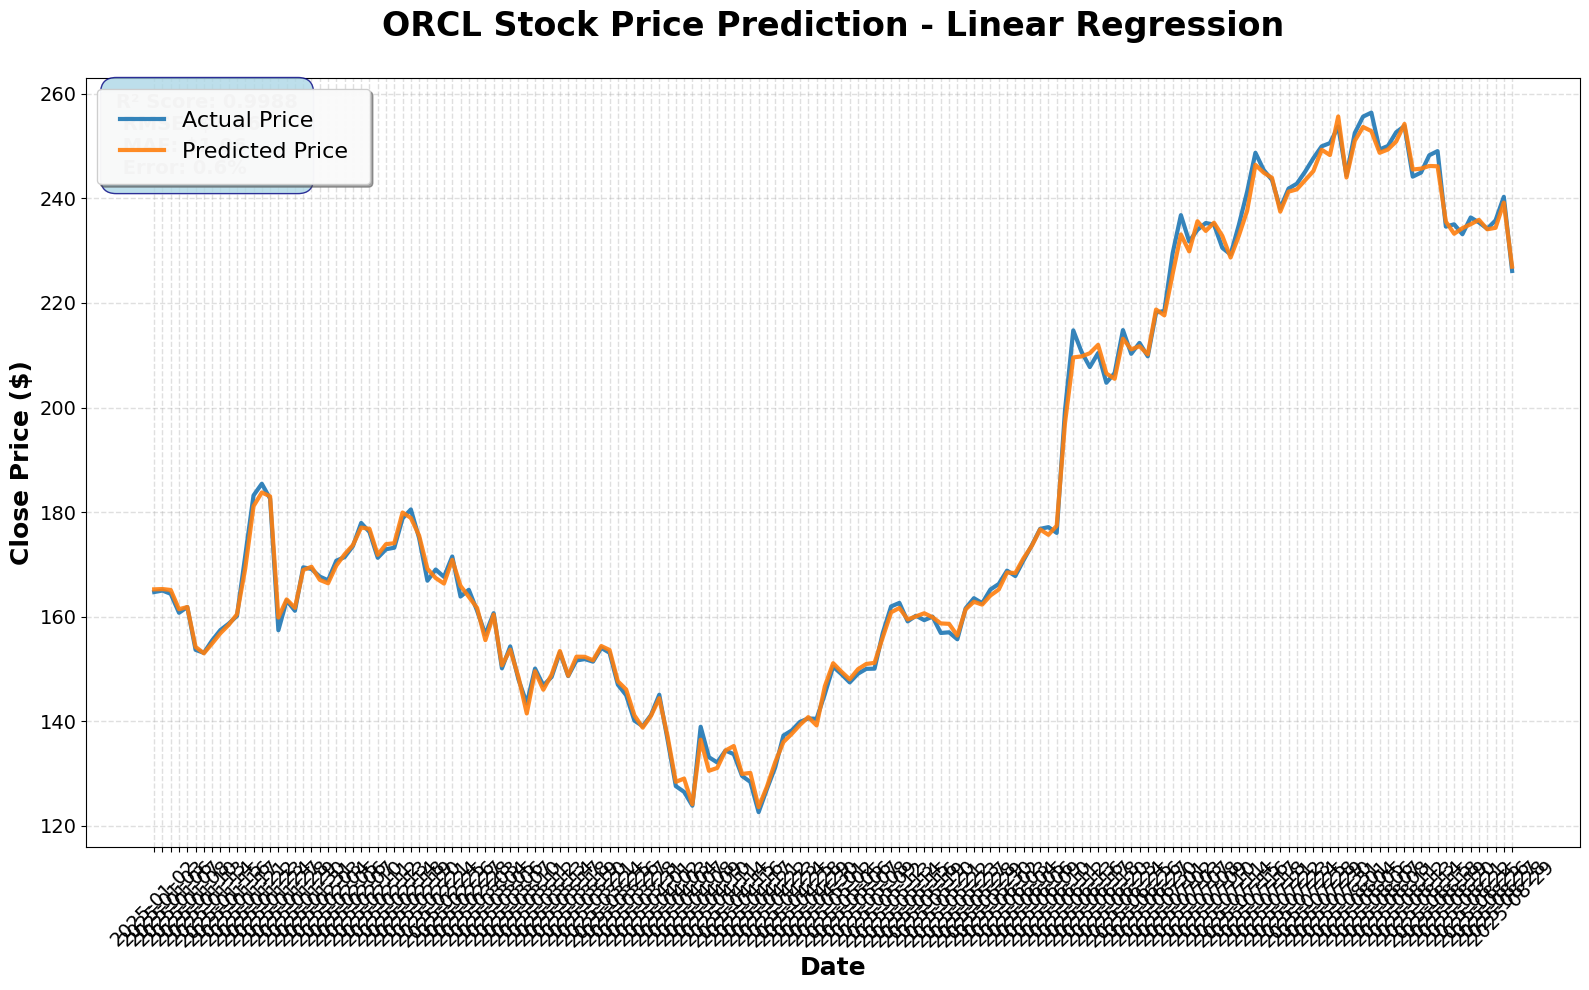


ANALYZING MSFT
Training set: 1239, Testing set: 165

Linear Regression Results:
RMSE: $1.78 | MAE: $1.28 | R²: 0.9988

Random Forest Results:
RMSE: $28.50 | MAE: $17.70 | R²: 0.6870

Gradient Boosting Results:
RMSE: $29.12 | MAE: $18.81 | R²: 0.6732

 BEST MODEL: Linear Regression (RMSE: $1.78)


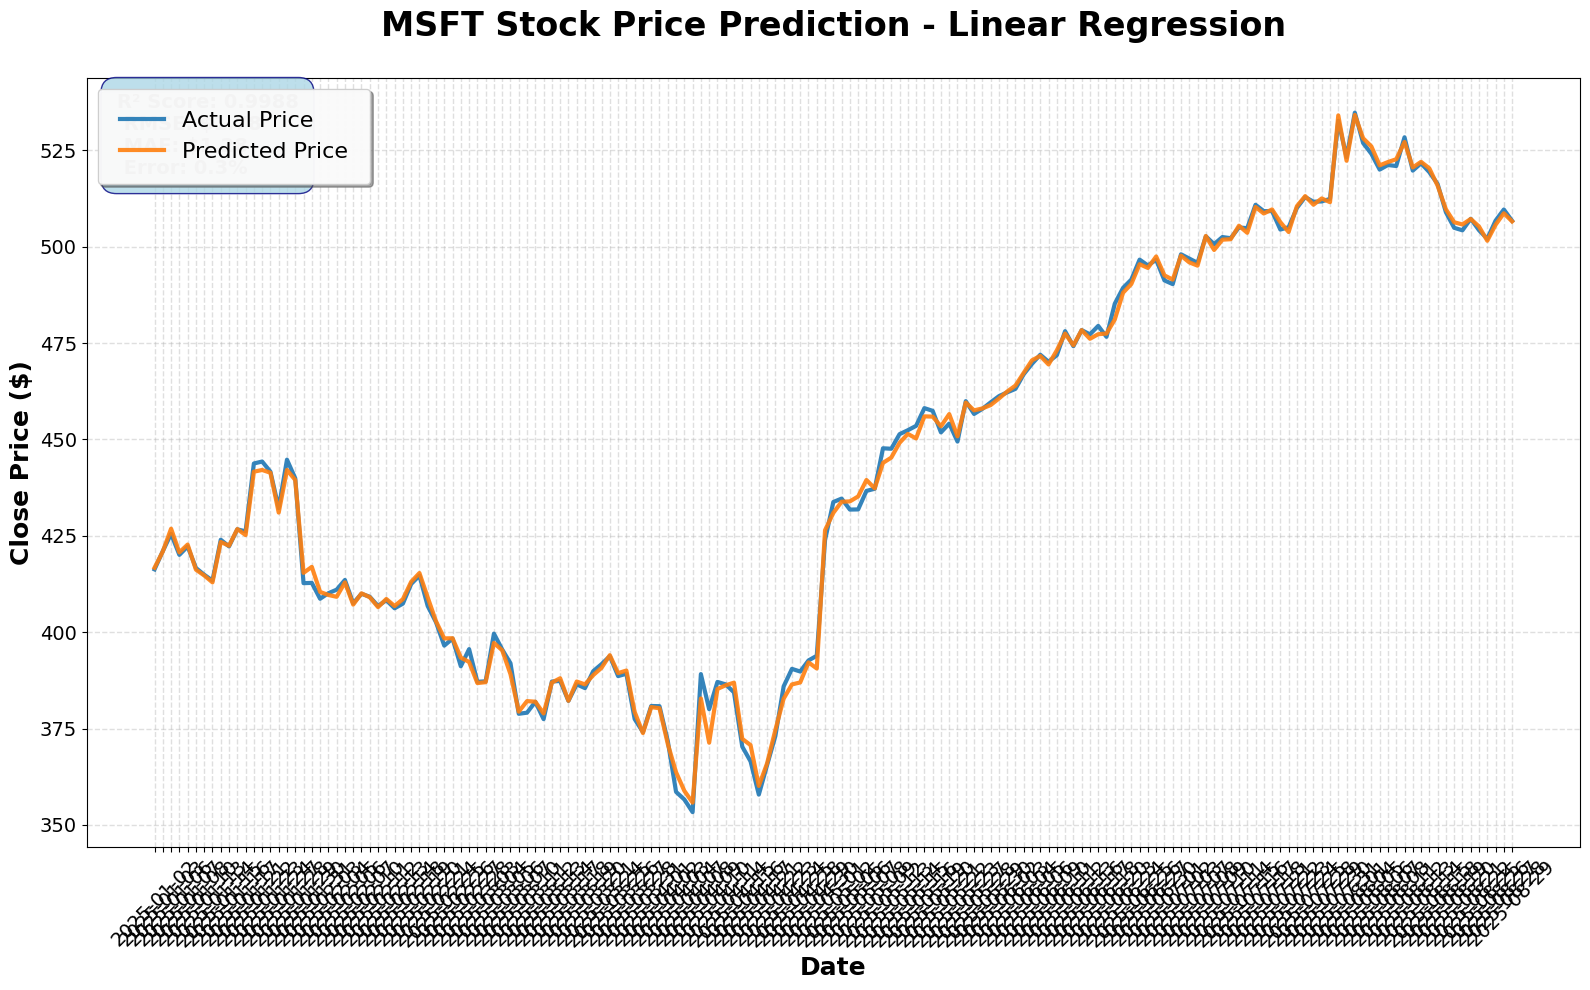


COMPREHENSIVE RESULTS SUMMARY

AAPL Results:
            Model     RMSE      MAE       R2  Error_%
Linear Regression 1.403254 1.069119 0.992074 0.493878
    Random Forest 3.592734 2.635704 0.948045 1.217559
Gradient Boosting 3.528181 2.669804 0.949895 1.233311
🏆 Best: Linear Regression (RMSE: $1.40)

META Results:
            Model      RMSE       MAE        R2  Error_%
Linear Regression  4.369061  3.395600  0.996358 0.515807
    Random Forest 72.659911 54.255938 -0.007248 8.241722
Gradient Boosting 69.511774 51.567830  0.078144 7.833386
🏆 Best: Linear Regression (RMSE: $4.37)

ORCL Results:
            Model      RMSE       MAE       R2  Error_%
Linear Regression  1.360463  1.062358 0.998833 0.582834
    Random Forest 27.748932 17.369821 0.514429 9.529475
Gradient Boosting 27.014927 17.051187 0.539777 9.354666
🏆 Best: Linear Regression (RMSE: $1.36)

MSFT Results:
            Model      RMSE       MAE       R2  Error_%
Linear Regression  1.782014  1.277306 0.998776 0.288076
    Rando

In [25]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Create a comprehensive analysis with multiple models
results_summary = []

for stock in stocks:
    print(f"\n{'='*60}")
    print(f"ANALYZING {stock}")
    print(f"{'='*60}")
    
    # Load the data
    df = pd.read_csv(
        f"{stock}_indicators.csv",
        index_col=0,       # use first column ("Date") as index
        parse_dates=[0],    # parse it as datetime
        date_format="ISO8601" #Specify date fromat
    )
    df = df.dropna()

    # Prepare features and target
    Y = df["Close"]
    X = df.drop(columns=["Close"])

    # Time-based split
    X_train, X_test = X[X.index < "2025-01-01"], X[X.index >= "2025-01-01"]
    y_train, y_test = Y[Y.index < "2025-01-01"], Y[Y.index >= "2025-01-01"]

    # Convert to numeric
    y_train = pd.to_numeric(y_train, errors='coerce')
    y_test = pd.to_numeric(y_test, errors='coerce')

    print(f"Training set: {len(X_train)}, Testing set: {len(X_test)}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define models to test
    models = {
        'Linear Regression': {
            'model': LinearRegression(),
            'use_scaled': True
        },
        'Random Forest': {
            'model': RandomForestRegressor(n_estimators=200, random_state=42),
            'use_scaled': False
        },
        'Gradient Boosting': {
            'model': GradientBoostingRegressor(n_estimators=200, random_state=42),
            'use_scaled': False
        }
    }

    best_model = None
    best_score = float('inf')
    best_name = ""
    
    # Train and evaluate all models
    for name, config in models.items():
        model = config['model']
        use_scaled = config['use_scaled']
        
        if use_scaled:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"\n{name} Results:")
        print(f"RMSE: ${rmse:.2f} | MAE: ${mae:.2f} | R²: {r2:.4f}")
        
        # Track best model
        if rmse < best_score:
            best_score = rmse
            best_model = (model, y_pred, use_scaled)
            best_name = name
        
        # Store results
        results_summary.append({
            'Stock': stock,
            'Model': name,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'Error_%': (mae/y_test.mean())*100
        })
    
    # Plot only the best model
    print(f"\n BEST MODEL: {best_name} (RMSE: ${best_score:.2f})")
    
    model, y_pred, use_scaled = best_model 
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Create the plot
    plt.figure(figsize=(16, 10))
    plt.plot(y_test.index, y_test, label='Actual Price', alpha=0.9, linewidth=3, color='#1f77b4')
    plt.plot(y_test.index, y_pred, label='Predicted Price', alpha=0.9, linewidth=3, color='#ff7f0e')

    # Enhanced title with correct model name
    plt.title(f"{stock} Stock Price Prediction - {best_name}", 
              fontsize=24, fontweight='bold', pad=30)
    plt.xlabel('Date', fontsize=18, fontweight='bold')
    plt.ylabel('Close Price ($)', fontsize=18, fontweight='bold')

    # Enhanced legend
    plt.legend(fontsize=16, loc='upper left', framealpha=0.95, shadow=True, 
               fancybox=True, borderpad=1)

    # Improved grid
    plt.grid(True, alpha=0.4, linestyle='--', linewidth=1)

    # Better tick formatting
    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)

    # Enhanced metrics box
    textstr = f'R² Score: {r2:.4f}\n RMSE: ${rmse:.2f}\n MAE: ${mae:.2f}\n Error: {(mae/y_test.mean())*100:.1f}%'
    props = dict(boxstyle='round,pad=0.8', facecolor='lightblue', alpha=0.8, edgecolor='navy')
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=14,
             verticalalignment='top', bbox=props, fontweight='bold')

    # Add feature importance if Random Forest or Gradient Boosting
    if best_name in ['Random Forest', 'Gradient Boosting'] and hasattr(model, 'feature_importances_'):
        top_features = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False).head(5)
        
        feature_text = " Top Features:\n" + "\n".join([f"{row['feature']}: {row['importance']:.3f}" 
                                                          for _, row in top_features.iterrows()])
        plt.text(0.98, 0.02, feature_text, transform=plt.gca().transAxes, fontsize=12,
                 verticalalignment='bottom', horizontalalignment='right',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7))

    plt.tight_layout()
    plt.show()

# Summary table of all results
print(f"\n{'='*80}")
print("COMPREHENSIVE RESULTS SUMMARY")
print(f"{'='*80}")

summary_df = pd.DataFrame(results_summary)
for stock in stocks:
    stock_results = summary_df[summary_df['Stock'] == stock]
    print(f"\n{stock} Results:")
    print(stock_results[['Model', 'RMSE', 'MAE', 'R2', 'Error_%']].to_string(index=False))
    
    # Highlight best model for each stock
    best_idx = stock_results['RMSE'].idxmin()
    best_model = summary_df.loc[best_idx]
    print(f"🏆 Best: {best_model['Model']} (RMSE: ${best_model['RMSE']:.2f})")